# ============================================================
# ML NOTEBOOK STRUCTURE: TWO NOTEBOOKS -> TWO ENVIRONMENTS
# ============================================================

# ---------------------------
# KERNEL 2: XGBoost / Optuna
# ---------------------------

# Install in xgb_env:
# pip install xgboost optuna pandas scikit-learn matplotlib joblib

In [1]:
# ======================================================================
# 0. IMPORTS
# ======================================================================
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import optuna
import joblib
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import os



In [2]:
#### Loading:
def load_data_with_chunks(local_paths, cloud_url=None, chunk_size=10**6):
    """
    Loads data in chunks, either locally or from the cloud.
    
    Args:
        local_paths (list): Paths to local CSV files.
        cloud_url (str): Google Drive/direct download URL (optional).
        chunk_size (int): Rows per chunk.
        filter_store_ids (list): List of store_nbrs to filter by (optional).
    
    Returns:
        pd.DataFrame: Combined data or None if failed.
    """
    # 1. Attempt: Load local file (with chunking)
    for path in local_paths:
        if os.path.exists(path):
            try:
                chunks = []
                for chunk in pd.read_csv(path, chunksize=chunk_size, sep=','):
                    chunks.append(chunk)
                df = pd.concat(chunks, ignore_index=True)
                print(f"Successfully loaded local data (chunked): {path}")
                return df
            except Exception as e:
                print(f"Error loading {path}: {e}")

    # 2. Attempt: Cloud source (if URL provided)
    if cloud_url:
        try:
            file_id = cloud_url.split('/')[-2]
            download_url = f'https://drive.google.com/uc?id={file_id}'
            
            chunks = []
            for chunk in pd.read_csv(download_url, chunksize=chunk_size, sep=','):
                chunks.append(chunk)
            df = pd.concat(chunks, ignore_index=True)
            print("Successfully loaded data from cloud (chunked)")
            return df
        except Exception as e:
            print(f"Cloud download failed: {e}")

    print("No data source was available")
    return None

# Example call
store_ids = [1, 5, 10]  # Example filter
df_final = load_data_with_chunks(
    local_paths=['../data/df_final_xgboost_full.csv'],
    cloud_url='https://drive.google.com/file/d/166SQFUQ6U9RC3yO8NElJqclxaEjv_8ro/view?usp=sharing'
)

# Preliminary data analysis
print(f"Dataset size: {df_final.shape}")
df_final.head()

Successfully loaded local data (chunked): ../data/df_final_xgboost_full.csv
Dataset size: (35692996, 20)


,store_nbr,item_nbr,date,unit_sales,onpromotion,z_score,year,month,day,weekday,type,family,rolling_std_7,lag_1,lag_7,lag_28,rolling_mean_7,lag_2,lag_3,lag_4
0,24,96995,2013-01-02,0.0,0,0.0,2013,1,2,2,Work Day,GROCERY I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24,96995,2013-01-03,0.0,0,0.0,2013,1,3,3,Work Day,GROCERY I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,24,96995,2013-01-04,0.0,0,0.0,2013,1,4,4,Work Day,GROCERY I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,24,96995,2013-01-05,0.0,0,0.0,2013,1,5,5,Work Day,GROCERY I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24,96995,2013-01-06,0.0,0,0.0,2013,1,6,6,Weekend,GROCERY I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df_final.columns

Index(['store_nbr', 'item_nbr', 'date', 'unit_sales', 'onpromotion', 'z_score',
       'year', 'month', 'day', 'weekday', 'type', 'family', 'rolling_std_7',
       'lag_1', 'lag_7', 'lag_28', 'rolling_mean_7', 'lag_2', 'lag_3',
       'lag_4'],
      dtype='object')

In [ ]:
df_final.drop(['z-score'], axis=1, inplace=True)

In [4]:
# ======================================================================
# 1. METRICS
# ======================================================================
def regression_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    bias = np.mean(y_pred - y_true)
    mad = np.mean(np.abs(y_pred - y_true))
    rmad = mad / np.mean(np.abs(y_true))

    # Safe MAPE: nur für y_true != 0
    mask = y_true != 0
    if np.any(mask):
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan  # keine gültigen Werte vorhanden

    return {
        "MAE": mae,
        "RMSE": rmse,
        "Bias": bias,
        "MAD": mad,
        "rMAD": rmad,
        "MAPE": mape
    }



In [5]:
# ======================================================================
# 2. FUTURE LEAKAGE PREVENTION
# ======================================================================

def prevent_future_leakage(df, lags, rollings):
    df = df.sort_values(["store_nbr", "item_nbr", "date"]).copy()

    for lag in lags:
        df[f"lag_{lag}"] = (
            df.groupby(["store_nbr", "item_nbr"])["unit_sales"]
            .shift(lag)
        )

    for win in rollings:
        df[f"rolling_mean_{win}"] = (
            df.groupby(["store_nbr", "item_nbr"])["unit_sales"]
            .shift(1).rolling(win).mean()
        )
        df[f"rolling_std_{win}"] = (
            df.groupby(["store_nbr", "item_nbr"])["unit_sales"]
            .shift(1).rolling(win).std()
        )

    lag_cols = [f"lag_{l}" for l in lags]
    rolling_cols = [f"rolling_mean_{w}" for w in rollings] + \
                   [f"rolling_std_{w}" for w in rollings]

    df[lag_cols + rolling_cols] = df[lag_cols + rolling_cols].fillna(0)

    return df

In [6]:

# ======================================================================
# 3. REMOVE HIGH CORRELATION
# ======================================================================

def remove_highly_correlated(df, threshold=0.95):
    df_num = df.select_dtypes(include=[np.number])
    corr = df_num.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    print("Entfernte korrelierte Features:", to_drop)

    return df.drop(columns=to_drop, errors="ignore")



In [7]:
# ======================================================================
# 4. CLEAN + FEATURE ENGINEERING
# ======================================================================

df = df_final.copy()

df["date"] = pd.to_datetime(df["date"])
df = df[df['date']>"2015-07-01"]

monthly_sales = df.groupby(['store_nbr', 'item_nbr', 'year', 'month'])['unit_sales'].sum().reset_index()

# 4️⃣ Nur Store-Item-Kombinationen behalten, die mindestens 1 Sale in diesem Monat hatten
active_monthly = monthly_sales[monthly_sales['unit_sales'] >= 1]

# 5️⃣ Merge zurück auf Original-DF, nur die aktiven Reihen behalten
df_filtered = df.merge(
    active_monthly[['store_nbr', 'item_nbr', 'year', 'month']],
    on=['store_nbr', 'item_nbr', 'year', 'month'],
    how='inner'
)


# 6️⃣ Sortieren
df_filtered = df_filtered.sort_values(["store_nbr", "item_nbr", "date"]).reset_index(drop=True)

print("Originale Zeilen:", len(df))
print("Nach Filterung (aktive Serien):", len(df_filtered))

Originale Zeilen: 16484884
Nach Filterung (aktive Serien): 13358641


In [26]:
df = df_filtered.copy()
n_series = df.groupby(['store_nbr', 'item_nbr']).ngroups
print("Anzahl der eindeutigen Store-Item-Kombinationen:", n_series)
n_series

Anzahl der eindeutigen Store-Item-Kombinationen: 20637


20637

In [9]:


lag_features = [1, 2, 3, 4, 7, 28]
rolling_features = [7]

df = prevent_future_leakage(df, lag_features, rolling_features)
df = remove_highly_correlated(df, threshold=0.95)

df["unit_sales_log"] = np.log1p(df["unit_sales"])

# Label Encoding
categorical_cols = ["type", "family"]
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le


Entfernte korrelierte Features: []


In [25]:
df


,store_nbr,item_nbr,date,unit_sales,onpromotion,z_score,year,month,day,weekday,...,family,rolling_std_7,lag_1,lag_7,lag_28,rolling_mean_7,lag_2,lag_3,lag_4,unit_sales_log
0,24,99197,2015-10-01,0.0,0,0.000000,2015,10,1,3,...,2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,24,99197,2015-10-02,0.0,0,0.000000,2015,10,2,4,...,2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,24,99197,2015-10-03,2.0,0,0.575917,2015,10,3,5,...,2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.098612
3,24,99197,2015-10-04,2.0,0,0.575917,2015,10,4,6,...,2,0.000000,2.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.098612
4,24,99197,2015-10-05,2.0,0,0.575917,2015,10,5,0,...,2,0.000000,2.0,0.0,0.0,0.000000,2.0,0.0,0.0,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13358636,51,2127114,2017-08-11,0.0,0,0.000000,2017,8,11,4,...,0,1.133893,0.0,0.0,0.0,0.428571,0.0,0.0,0.0,0.000000
13358637,51,2127114,2017-08-12,0.0,0,0.000000,2017,8,12,5,...,0,1.133893,0.0,0.0,0.0,0.428571,0.0,0.0,0.0,0.000000
13358638,51,2127114,2017-08-13,0.0,0,0.000000,2017,8,13,6,...,0,1.133893,0.0,3.0,0.0,0.428571,0.0,0.0,0.0,0.000000
13358639,51,2127114,2017-08-14,0.0,0,0.000000,2017,8,14,0,...,0,0.000000,0.0,0.0,3.5,0.000000,0.0,0.0,0.0,0.000000


In [10]:
# ======================================================================
# 5. TRAIN/TEST SPLIT (ZEITBASIERT)
# ======================================================================

SPLIT_DATE = "2017-07-02"

train_df = df[df["date"] < SPLIT_DATE]
test_df  = df[df["date"] >= SPLIT_DATE]

# Test-Daten
X_test = test_df.drop(columns=["unit_sales", "unit_sales_log", "date"])
y_test = test_df["unit_sales_log"]

In [11]:
# ======================================================================
# 6. SLIDING WINDOW CROSS VALIDATION (EXTREM SCHNELL)
# ======================================================================

def build_time_windows(dates, window_train_weeks=26, window_val_weeks=4, n_folds=3):
    max_date = dates.max()
    windows = []

    for i in range(n_folds):
        val_end = max_date - pd.Timedelta(weeks=i * window_val_weeks)
        val_start = val_end - pd.Timedelta(weeks=window_val_weeks)

        train_end = val_start - pd.Timedelta(days=1)
        train_start = train_end - pd.Timedelta(weeks=window_train_weeks)

        windows.append({
            "train_start": train_start,
            "train_end": train_end,
            "val_start": val_start,
            "val_end": val_end
        })
    return windows


def sliding_window_cv(model, df, windows):
    rmses = []

    for w in windows:
        train = df[(df.date >= w["train_start"]) & (df.date <= w["train_end"])]
        val   = df[(df.date >= w["val_start"])   & (df.date <= w["val_end"])]

        X_train = train.drop(columns=["unit_sales", "unit_sales_log", "date"])
        y_train = train["unit_sales_log"]
        X_val   = val.drop(columns=["unit_sales", "unit_sales_log", "date"])
        y_val   = val["unit_sales_log"]

        scaler = StandardScaler()
        X_train_sc = scaler.fit_transform(X_train)
        X_val_sc   = scaler.transform(X_val)


        model.fit(
            X_train_sc, y_train,
            eval_set=[(X_val_sc, y_val)],
            verbose=False
        )

        y_pred = model.predict(X_val_sc)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

    return np.mean(rmses)


In [12]:
# ======================================================================
# 7. OPTUNA OBJECTIVE
# ======================================================================

def optuna_objective(trial):

    params = {
        "tree_method": "hist",
        "objective": "reg:squarederror",
        "random_state": 42,
        "n_jobs": 1,
        "n_estimators": trial.suggest_int("n_estimators", 300, 900),
        "max_depth": trial.suggest_int("max_depth", 5, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
    }

    model = XGBRegressor(**params)

    # CV Windows definieren
    windows = build_time_windows(
        dates=train_df["date"],
        window_train_weeks=26,
        window_val_weeks=4,
        n_folds=3
    )

    rmse = sliding_window_cv(model, train_df, windows)
    return rmse



In [13]:
# ======================================================================
# 8. MLflow SETUP
# ======================================================================

mlruns_path = "/Users/alex/Time-Series-Projekt/Favorita-Projekt/mlruns2"
os.makedirs(mlruns_path, exist_ok=True)

mlflow.set_tracking_uri(f"file:{mlruns_path}")

experiment_name = "favorita_sales_forecasting_Optuna_XGBoost_HyperOpt_v2"
mlflow.set_experiment(experiment_name)


# ============================================================
# 3. Sicherstellen, dass kein MLflow-Run offen ist
# (SEHR WICHTIG — verhindert verschachtelte Runs)
# ============================================================
if mlflow.active_run() is not None:
    mlflow.end_run()



/Users/alex/anaconda3/envs/xgb_env/lib/python3.10/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


In [ ]:

# ======================================================================
# 9. OPTUNA START + MLflow Callback
# ======================================================================
def mlflow_optuna_callback(study, trial):
    run = mlflow.start_run(
        run_name=f"trial_{trial.number}",
        nested=True
    )
    
    mlflow.log_params(trial.params)
    mlflow.log_metric("RMSE", trial.value)

    mlflow.end_run()


# Hier soll eigener Pfad für die SQLite DB hin
storage_path = "/Users/alex/Time-Series-Projekt/Favorita-Projekt/optuna_favorita_v2.db"

study = optuna.create_study(
    direction="minimize",
    study_name="favorita_xgb_opt_v2",
    storage=f"sqlite:///{storage_path}",
    load_if_exists=False
)
N_TRIALS = 30

# Falls du fortsetzen willst:
missing_trials = N_TRIALS - len(study.trials)
study.optimize(optuna_objective, n_trials=missing_trials, callbacks=[mlflow_optuna_callback])

print("Beste Parameter:", study.best_trial.params)
print("Bester RMSE:", study.best_value)


[I 2025-11-27 09:51:14,442] Using an existing study with name 'favorita_xgb_opt_v2' instead of creating a new one.


Beste Parameter: {'n_estimators': 359, 'max_depth': 12, 'learning_rate': 0.1247146474421679, 'subsample': 0.7371547944632592, 'colsample_bytree': 0.9449721784485826, 'gamma': 0.15108860451367678, 'reg_alpha': 3.749129154437335, 'reg_lambda': 4.428743279906986}
Bester RMSE: 0.16273957588190466


In [15]:
# ======================================================================
# 9. BESTES MODELL TRAINIEREN
# ======================================================================

best_params = study.best_params
best_model = XGBRegressor(
    **best_params,
    tree_method="hist",
    objective="reg:squarederror",
    random_state=42,
    n_jobs=1
)

# Finales Train-Set = alle Trainingsdaten
X_train_final = train_df.drop(columns=["unit_sales", "unit_sales_log", "date"])
y_train_final = train_df["unit_sales_log"]

scaler = StandardScaler()
X_train_final_sc = scaler.fit_transform(X_train_final)
X_test_sc = scaler.transform(X_test)

best_model.fit(X_train_final_sc, y_train_final)

final_pred = best_model.predict(X_test_sc)

metrics = regression_metrics(y_test, final_pred)

# =====================================================
# 🔥 1. Rücktransformation
# =====================================================
y_pred = np.expm1(final_pred)
y_true = np.expm1(y_test)
y_pred = np.maximum(0, np.expm1(final_pred))

In [16]:
model_dir = "../models"
os.makedirs(model_dir, exist_ok=True)

# Alles gemeinsam speichern
joblib.dump({
    "model": best_model,
    "scaler": scaler,
    "features": list(X_train_final.columns),
    "best_params": best_params,
    "metrics": metrics
}, os.path.join(model_dir, "xgb_final_model_v2.pkl"))

print("Modell erfolgreich gespeichert!")

Modell erfolgreich gespeichert!


In [17]:
print(y_true.describe())

count    829201.000000
mean          3.765282
std          10.056197
min           0.000000
25%           0.000000
50%           2.000000
75%           4.000000
max        1981.000000
Name: unit_sales_log, dtype: float64


In [18]:
# =====================================================
# 🔥 2. Metriken berechnen (echte Sales!)
# =====================================================
metrics = regression_metrics(y_true, y_pred)
display("Final metrics (real scale):", metrics)


'Final metrics (real scale):'

{'MAE': np.float64(0.6204835537322474),
 'RMSE': np.float64(4.412887682462678),
 'Bias': np.float64(-0.09046252795244736),
 'MAD': np.float64(0.6204835537322474),
 'rMAD': np.float64(0.16479072713210033),
 'MAPE': np.float64(16.054457824145345)}

In [19]:
# =====================================================
# 🔥 3. MLflow – JETZT loggen!
# =====================================================
with mlflow.start_run(run_name="Final_Model"):
    mlflow.log_params(best_params)

    # Echte Metriken loggen
    for k, v in metrics.items():
        mlflow.log_metric(k, v)

    # Modell speichern
    input_example = X_train_final.iloc[:1].copy()
    input_example = input_example.astype(float)

    mlflow.sklearn.log_model(
        best_model,
        name="xgb_final_model",
        input_example=input_example
    )



In [20]:


# test_dates: ab 1.07.2017 bis 31.08.2017
test_dates = pd.date_range(start="2017-07-02", end="2017-08-15")
'''
# Anzahl der Serien (Store-Item Kombinationen)
n_series = len(y_test) // len(test_dates)

# DataFrame für alle Testdaten
df_pred = pd.DataFrame({
    "y_true": y_test,
    "y_pred": final_pred,
    "store_item_id": np.repeat(np.arange(n_series), len(test_dates)),
    "date": np.tile(test_dates, n_series)
})
'''
n_series = len(y_test) // len(test_dates)
if n_series * len(test_dates) != len(y_test):
    print(f"Achtung: y_test Länge {len(y_test)} passt nicht exakt zu {len(test_dates)} * n_series {n_series}")
# Kürze oder erweitere Arrays ggf.
n_total = n_series * len(test_dates)
y_true_arr = y_test[:n_total]
y_pred_arr = final_pred[:n_total]

store_item_arr = np.repeat(np.arange(n_series), len(test_dates))
date_arr = np.tile(test_dates, n_series)
df_pred = pd.DataFrame({
    "y_true": y_true_arr,
    "y_pred": y_pred_arr,
    "store_item_id": store_item_arr,
    "date": date_arr
})

Achtung: y_test Länge 829201 passt nicht exakt zu 45 * n_series 18426


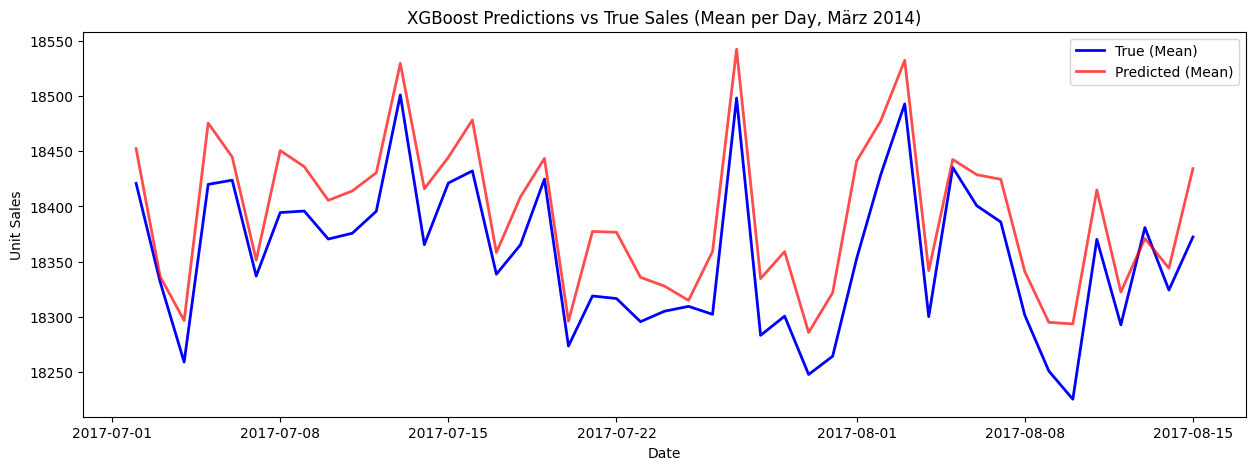

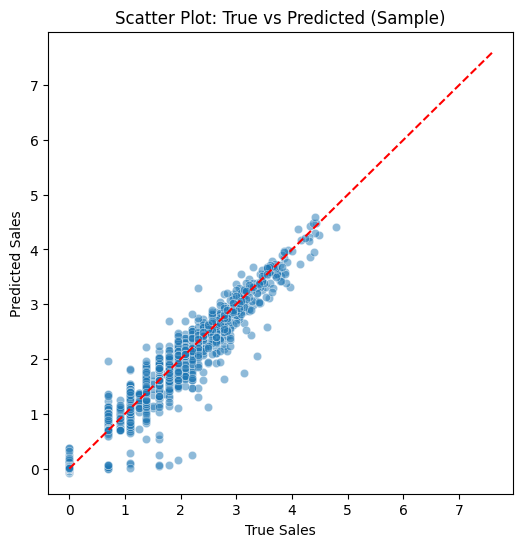

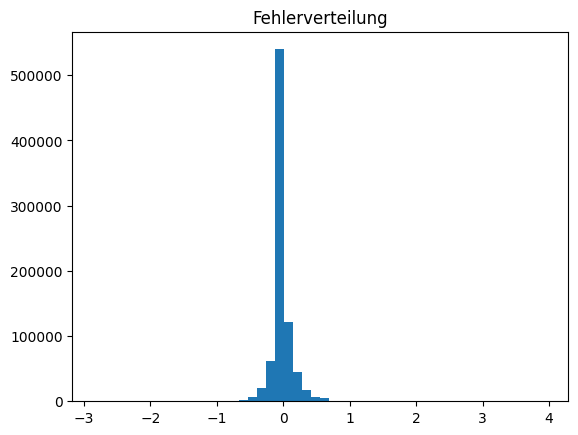

In [23]:


# =========================
# 1. Aggregierte Visualisierung (Mittelwert pro Tag)
# =========================
df_agg = df_pred.groupby('date')[['y_true','y_pred']].sum().reset_index()

plt.figure(figsize=(15,5))
plt.plot(df_agg['date'], df_agg['y_true'], label='True (Mean)', color='blue', linewidth=2)
plt.plot(df_agg['date'], df_agg['y_pred'], label='Predicted (Mean)', color='red', alpha=0.7, linewidth=2)
plt.title('XGBoost Predictions vs True Sales (Mean per Day, März 2014)')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.legend()
plt.show()

# =========================
# 2. Scatter Plot (Sample, alle Series)
# =========================
plt.figure(figsize=(6,6))
sns.scatterplot(
    x='y_true', y='y_pred', 
    data=df_pred.sample(5000, random_state=42), 
    alpha=0.5
)
plt.plot([0, df_pred['y_true'].max()], [0, df_pred['y_true'].max()], 'r--')
plt.xlabel('True Sales')
plt.ylabel('Predicted Sales')
plt.title('Scatter Plot: True vs Predicted (Sample)')
plt.show()

errors = df_pred['y_true'] - df_pred['y_pred']
plt.hist(errors, bins=50)
plt.title("Fehlerverteilung")
plt.show()


In [24]:
df.to_csv('../data/df_for_production_v2.csv', index=False)

# Forhersage für test daten

In [69]:
df_test=pd.read_csv("../data/test.csv", sep=',')
df_test.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [70]:
df_holidays=pd.read_csv("../data/holidays_events.csv", sep=',')
df_holidays = df_holidays[df_holidays['date'] >= '2017-08-16']

In [71]:
test_df = df_test.copy()  
test_df["date"] = pd.to_datetime(test_df["date"])

In [ ]:
print(f"{test_df['date'].max()}")

2017-08-31 00:00:00


: 

In [72]:
df_filtered["unit_sales_log"] = np.log1p(df["unit_sales"])

In [73]:
# 1️⃣ Kopiere future DataFrame
future_ready = test_df.copy()
future_ready['date'] = pd.to_datetime(future_ready['date'])

# 2️⃣ Merge 'family' aus train_df
future_ready = future_ready.merge(
    df_filtered[['store_nbr','item_nbr','family']].drop_duplicates(),
    on=['store_nbr','item_nbr'],
    how='left'
)

# 3️⃣ Merge 'type' aus holidays_df
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
future_ready = future_ready.merge(
    df_holidays[['date','type']].drop_duplicates(),
    on='date',
    how='left'
)

# 4️⃣ Filter auf gültige Kombinationen
valid_combinations = set(zip(train_df['store_nbr'], train_df['item_nbr']))
future_ready = future_ready[
    future_ready.apply(lambda row: (row['store_nbr'], row['item_nbr']) in valid_combinations, axis=1)
].copy()

# 5️⃣ Datumsspalten
future_ready['year'] = future_ready['date'].dt.year
future_ready['month'] = future_ready['date'].dt.month
future_ready['day'] = future_ready['date'].dt.day
future_ready['weekday'] = future_ready['date'].dt.weekday

# 6️⃣ z_score auf 0 setzen
future_ready['z_score'] = 0
future_ready.drop(['id'], axis=1, inplace=True)
# --- future_ready ist jetzt vollständig vorbereitet ---
future_ready.head()


,date,store_nbr,item_nbr,onpromotion,family,type,year,month,day,weekday,z_score
89724,2017-08-16,24,99197,False,GROCERY I,NaN,2017,8,16,2,0
89726,2017-08-16,24,103520,False,GROCERY I,NaN,2017,8,16,2,0
89728,2017-08-16,24,105574,False,GROCERY I,NaN,2017,8,16,2,0
89729,2017-08-16,24,105575,False,GROCERY I,NaN,2017,8,16,2,0
89731,2017-08-16,24,105577,False,GROCERY I,NaN,2017,8,16,2,0


In [74]:
future_ready.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313072 entries, 89724 to 3358724
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         313072 non-null  datetime64[ns]
 1   store_nbr    313072 non-null  int64         
 2   item_nbr     313072 non-null  int64         
 3   onpromotion  313072 non-null  bool          
 4   family       313072 non-null  object        
 5   type         19567 non-null   object        
 6   year         313072 non-null  int32         
 7   month        313072 non-null  int32         
 8   day          313072 non-null  int32         
 9   weekday      313072 non-null  int32         
 10  z_score      313072 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int32(4), int64(3), object(2)
memory usage: 21.8+ MB


In [75]:
future_ready['weekday'] = pd.to_datetime(future_ready['date']).dt.weekday
# Create mask for weekends (Saturday/Sunday) with missing type
mask_we = (future_ready['type'].isna() & 
          (future_ready['weekday'].isin([5,6])))

# Create mask for workdays (Monday-Friday) with missing type
mask_wd = (future_ready['type'].isna() & 
          (~future_ready['weekday'].isin([5,6])))

# Assign 'WE' type to weekend days
future_ready.loc[mask_we, 'type'] = 'Weekend'
# Assign 'Work Day' type to weekdays
future_ready.loc[mask_wd, 'type'] = 'Work Day'

# Display the updated data
future_ready.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313072 entries, 89724 to 3358724
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         313072 non-null  datetime64[ns]
 1   store_nbr    313072 non-null  int64         
 2   item_nbr     313072 non-null  int64         
 3   onpromotion  313072 non-null  bool          
 4   family       313072 non-null  object        
 5   type         313072 non-null  object        
 6   year         313072 non-null  int32         
 7   month        313072 non-null  int32         
 8   day          313072 non-null  int32         
 9   weekday      313072 non-null  int32         
 10  z_score      313072 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int32(4), int64(3), object(2)
memory usage: 21.8+ MB


In [76]:
# Kombiniere historisch + future_ready für Lags/Rollings
combined = pd.concat([train_df, future_ready], ignore_index=True)
combined = combined.sort_values(["store_nbr","item_nbr","date"])

lag_features = [1,2,3,4,7,28]
rolling_features = [7]

combined = prevent_future_leakage(combined, lag_features, rolling_features)
combined = remove_highly_correlated(combined)

# Extrahiere nur future_ready Teil
future_ready = combined[combined['date'] >= future_ready['date'].min()].copy()




Entfernte korrelierte Features: []


In [77]:
future_ready

,store_nbr,item_nbr,date,unit_sales,onpromotion,z_score,year,month,day,weekday,...,family,rolling_std_7,lag_1,lag_7,lag_28,rolling_mean_7,lag_2,lag_3,lag_4,unit_sales_log
12529440,24,99197,2017-08-16,NaN,0,0.0,2017,8,16,2,...,GROCERY I,1.069045,2.0,2.0,0.0,0.857143,0.0,0.0,0.0,NaN
12549007,24,99197,2017-08-17,NaN,0,0.0,2017,8,17,3,...,GROCERY I,0.000000,0.0,2.0,0.0,0.000000,2.0,0.0,0.0,NaN
12568574,24,99197,2017-08-18,NaN,0,0.0,2017,8,18,4,...,GROCERY I,0.000000,0.0,0.0,0.0,0.000000,0.0,2.0,0.0,NaN
12588141,24,99197,2017-08-19,NaN,0,0.0,2017,8,19,5,...,GROCERY I,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,2.0,NaN
12607708,24,99197,2017-08-20,NaN,0,0.0,2017,8,20,6,...,GROCERY I,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12764243,51,2127114,2017-08-27,NaN,0,0.0,2017,8,27,6,...,BEVERAGES,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,NaN
12783810,51,2127114,2017-08-28,NaN,0,0.0,2017,8,28,0,...,BEVERAGES,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,NaN
12803377,51,2127114,2017-08-29,NaN,0,0.0,2017,8,29,1,...,BEVERAGES,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,NaN
12822944,51,2127114,2017-08-30,NaN,0,0.0,2017,8,30,2,...,BEVERAGES,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,NaN


In [78]:
# LabelEncoder anwenden
for col, le in encoders.items():
    if col in future_ready.columns:
        # Markiere unbekannte Werte
        future_ready[col] = future_ready[col].apply(lambda x: x if x in le.classes_ else 'unseen')
        
        # Falls "unseen" nicht in le.classes_ existiert, hinzufügen
        if 'unseen' not in le.classes_:
            le.classes_ = np.append(le.classes_, 'unseen')
        
        # Jetzt transformieren
        future_ready[col] = le.transform(future_ready[col])

# Features für Modell
drop_cols = ["date", "unit_sales", "unit_sales_log"]
X_future = future_ready.drop(columns=[c for c in drop_cols if c in future_ready.columns])

# Vorhersage
X_scaled = scaler.transform(X_future)
y_pred_log = best_model.predict(X_scaled)
y_pred = np.expm1(y_pred_log)
y_pred = np.maximum(y_pred, 0)

# Forecast DataFrame
future_ready['forecast'] = y_pred
forecast_df = future_ready[['date','store_nbr','item_nbr','forecast']].copy()

In [83]:
forecast_df

,date,store_nbr,item_nbr,forecast
12529440,2017-08-16,24,99197,0.001777
12549007,2017-08-17,24,99197,0.001158
12568574,2017-08-18,24,99197,0.004464
12588141,2017-08-19,24,99197,0.009184
12607708,2017-08-20,24,99197,0.008390
...,...,...,...,...
12764243,2017-08-27,51,2127114,0.009303
12783810,2017-08-28,51,2127114,0.005618
12803377,2017-08-29,51,2127114,0.005682
12822944,2017-08-30,51,2127114,0.005781


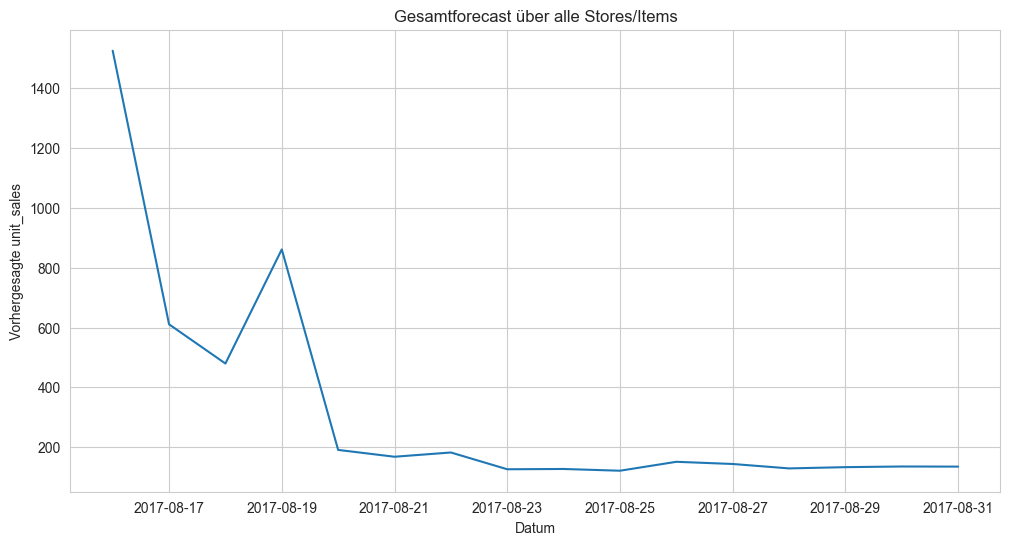

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Für konsistente Stilgebung
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

# ------------------------------
# 1️⃣ Gesamtforecast über alle Stores/Items
# ------------------------------
agg_forecast = forecast_df.groupby('date')['forecast'].sum().reset_index()

plt.figure()
sns.lineplot(data=agg_forecast, x='date', y='forecast')
plt.title("Gesamtforecast über alle Stores/Items")
plt.xlabel("Datum")
plt.ylabel("Vorhergesagte unit_sales")
plt.show()





In [82]:
forecast_df.to_csv('../data/forecast_df_v2.csv', index=False)